<b>Bayesian Network:</b> A Bayesian Network consists of a directed graph and a conditional probability distribution associated with each of the random variables. A Bayesian network is used mostly when there is a causal relationship between the random variables.<br>
<br>
vs.<br>
<br>
<b>Markov Network:</b> A Markov Network consists of an undi- rected graph and a few Factors are associated with it. Unlike Conditional Probability Distributions, a Factor does not rep- resent the probabilities of variables in the network; instead it represents the compatibility between random variables that is how much a particular state of a random variable likely to agree with the another state of some other random variable.

A Bayesian Network consists of a directed graph where nodes represents random variables and edges represent the the relation between them. 
- It is parameterized using Conditional Probability Distributions (CPD). 
- Each random variable in a Bayesian Network has a CPD associated with it. 
- If a random varible has parents in the network then the CPD represents P(var|Parvar) i.e. the probability of that variable given its parents. 
- In the case, when the random variable has no parents it simply represents P(var) i.e. the probability of that variable.

https://conference.scipy.org/proceedings/scipy2015/pdfs/ankur_ankan.pdf

In [1]:
import pandas as pd
import numpy as np
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.inference import VariableElimination
from sklearn.cross_validation import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/Users/nmolivo/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('../assets/04_model_2_data.csv')

In [3]:
data.head()

,Unnamed: 0,Fatal (Y/N),ts_date,ts_year,geo_country,gmtoffset,phase,pop_lag,Boat,Boating,...,Disaster_act,Diving_act,Filming_act,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act
0,0,0,11/30/17,2017,Costa Rica,-6,2,15.395988,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,1,11/30/17,2017,Costa Rica,-6,2,15.395988,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,1,11/25/17,2017,Libya,3,2,15.654989,0,0,...,1,0,0,0,0,0,0,0,0,0
3,3,1,2/8/09,2009,United States,-4,3,19.532847,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,8/16/08,2008,United States,-4,3,19.523389,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
data.columns

Index(['Unnamed: 0', 'Fatal (Y/N)', 'ts_date', 'ts_year', 'geo_country',
       'gmtoffset', 'phase', 'pop_lag', 'Boat', 'Boating', 'Provoked',
       'Sea Disaster', 'Unprovoked', 'Boating_act', 'Disaster_act',
       'Diving_act', 'Filming_act', 'Fishing_act', 'Handling_act',
       'Rowing_act', 'Shallow Water_act', 'Spear Fishing_act', 'Surfing_act',
       'Swimming_act'],
      dtype='object')

In [5]:
data = data.drop(['Unnamed: 0','gmtoffset'], axis =1)

print(len(data))
data.dropna(inplace=True)
print(len(data))

1227
1210


In [6]:
data.rename(columns={"Fatal (Y/N)": 'fatal', "ts_date": 'month', "ts_year": 'year'}, inplace=True)
data['month'] = data['month'].apply(lambda x: int(str(x).split('/')[0]))
data.head()

,fatal,month,year,geo_country,phase,pop_lag,Boat,Boating,Provoked,Sea Disaster,...,Disaster_act,Diving_act,Filming_act,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act
0,0,11,2017,Costa Rica,2,15.395988,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,11,2017,Costa Rica,2,15.395988,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,11,2017,Libya,2,15.654989,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,1,2,2009,United States,3,19.532847,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,0,8,2008,United States,3,19.523389,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# to sum a total count of attacks
data['attack'] = 1

# create a country-year-month dataset to have all the times where a shark attack didn't happen, too.
# pop_lag is the same in every month for each country-year
cym = pd.DataFrame(data.groupby(('geo_country', 'year', 'month', 'pop_lag')).sum()) 
cym.reset_index(inplace=True)

# sometimes a single month will have more than one phase, we'll keep the max phase
del cym['phase']
cym = cym.merge(data[['geo_country', 'year', 'month', 'phase']], on=['geo_country', 'year', 'month'], how='left')
cym.drop_duplicates(subset=['geo_country', 'year', 'month'], keep='last', inplace=True)
cym.head()

,geo_country,year,month,pop_lag,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,...,Filming_act,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act,attack,phase
0,Aruba,2015,12,11.550173,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2
2,Australia,2007,1,16.845543,0,0,0,0,0,2,...,0,0,0,0,0,0,1,0,2,4
3,Australia,2007,2,16.845543,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,3
5,Australia,2007,3,16.845543,0,0,0,0,0,2,...,0,0,0,0,0,0,1,1,2,4
7,Australia,2007,5,16.845543,0,0,0,0,0,2,...,0,0,0,0,1,0,1,0,2,1


In [8]:
# fill in the empty years
n_countries = cym['geo_country'].nunique()
n_years = cym['year'].nunique()
n_months = cym['month'].nunique()

In [9]:
countries = [c for country in list(cym['geo_country'].unique()) for c in [country]*(n_years*n_months)]
years = [y for year in sorted(list(cym['year'].unique()))*n_countries for y in [year]*n_months]
months = [m for m in sorted(list(cym['month'].unique()))*(n_countries*n_years)]

In [10]:
full_cym = pd.DataFrame(list(zip(countries, years, months)), columns=['geo_country', 'year', 'month'])

In [11]:
full_cym = full_cym.merge(cym, on=['geo_country', 'year', 'month'], how='left')
full_cym.head()

,geo_country,year,month,pop_lag,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,...,Filming_act,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act,attack,phase
0,Aruba,2007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,2007,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,2007,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,2007,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,2007,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# linearly interpolate the population data
int_pop = pd.DataFrame(full_cym.groupby(['geo_country', 'year'])['pop_lag'].mean()).reset_index()
int_pop.head()

,geo_country,year,pop_lag
0,Aruba,2007,NaN
1,Aruba,2008,NaN
2,Aruba,2009,NaN
3,Aruba,2010,NaN
4,Aruba,2011,NaN


In [13]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html
int_pop = int_pop.groupby('geo_country').apply(lambda group: group.interpolate(method='linear', limit_direction='both', 
                                                                     limit=n_years))

In [14]:
full_cym = full_cym.merge(int_pop, on=['geo_country', 'year'], how='left')
full_cym.head()

,geo_country,year,month,pop_lag_x,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,...,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act,attack,phase,pop_lag_y
0,Aruba,2007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
1,Aruba,2007,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
2,Aruba,2007,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
3,Aruba,2007,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173
4,Aruba,2007,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.550173


In [15]:
del full_cym['pop_lag_x']
full_cym.rename(columns={'pop_lag_y': 'log_pop'}, inplace=True)
full_cym.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8712 entries, 0 to 8711
Data columns (total 23 columns):
geo_country          8712 non-null object
year                 8712 non-null int64
month                8712 non-null int64
fatal                546 non-null float64
Boat                 546 non-null float64
Boating              546 non-null float64
Provoked             546 non-null float64
Sea Disaster         546 non-null float64
Unprovoked           546 non-null float64
Boating_act          546 non-null float64
Disaster_act         546 non-null float64
Diving_act           546 non-null float64
Filming_act          546 non-null float64
Fishing_act          546 non-null float64
Handling_act         546 non-null float64
Rowing_act           546 non-null float64
Shallow Water_act    546 non-null float64
Spear Fishing_act    546 non-null float64
Surfing_act          546 non-null float64
Swimming_act         546 non-null float64
attack               546 non-null float64
phase        

In [16]:
# fill everything else with 0s, because there was nothing that country-year-month
full_cym.fillna(0, inplace=True)

In [17]:
full_cym.head()

,geo_country,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,Boating_act,...,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act,attack,phase,log_pop
0,Aruba,2007,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
1,Aruba,2007,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
2,Aruba,2007,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
3,Aruba,2007,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173
4,Aruba,2007,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173


In [18]:
# turn the log of population into a discrete variable for use in the Bayesian network
full_cym['log_pop_cat'] = pd.cut(full_cym['log_pop'], 10, labels=range(10))
full_cym.head()

,geo_country,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,Boating_act,...,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act,attack,phase,log_pop,log_pop_cat
0,Aruba,2007,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
1,Aruba,2007,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
2,Aruba,2007,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
3,Aruba,2007,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2
4,Aruba,2007,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.550173,2


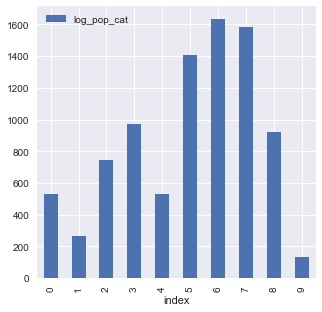

In [19]:
# do the bins look right? Yes they do.
pop_cat = pd.DataFrame(full_cym.log_pop_cat.value_counts())
pop_cat.reset_index(inplace=True)
pop_cat.sort_values(by='index', inplace=True)
pop_cat.plot(x='index', y='log_pop_cat', kind='bar', figsize=(5, 5))

In [20]:
del full_cym['log_pop']
full_cym.head()

,geo_country,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,Boating_act,...,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act,attack,phase,log_pop_cat
0,Aruba,2007,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,Aruba,2007,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Aruba,2007,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Aruba,2007,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,Aruba,2007,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [21]:
full_cym.describe()

,year,month,fatal,Boat,Boating,Provoked,Sea Disaster,Unprovoked,Boating_act,Disaster_act,...,Filming_act,Fishing_act,Handling_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act,attack,phase
count,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,...,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000
mean,2012.000000,6.500000,0.011134,0.001492,0.006543,0.012282,0.001148,0.117424,0.000689,0.001033,...,0.000344,0.014463,0.003558,0.005165,0.009986,0.008494,0.054178,0.026056,0.138889,0.160698
std,3.162459,3.452251,0.111306,0.041470,0.096207,0.121070,0.033862,0.700532,0.026236,0.032126,...,0.018555,0.138119,0.063287,0.092645,0.140571,0.096650,0.387858,0.228566,0.784708,0.681607
min,2007.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2009.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2012.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,9.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2017.000000,12.000000,2.000000,2.000000,3.000000,2.000000,1.000000,13.000000,1.000000,1.000000,...,1.000000,4.000000,2.000000,5.000000,6.000000,2.000000,9.000000,7.000000,15.000000,4.000000


<b>DAG (pattern) construction</b><br>
Given the set of conditional independencies in a probability distribution, we try to find a DAG for which the Markov condition entails all and only those conditional independencies (test for conditional independence using the Chi-squared test).

1. Construct an undirected skeleton - estimate_skeleton()
2. Orient compelled edges to obtain partially directed acyclid graph (PDAG; I-equivalence class of DAGs) - skeleton_to_pdag()
3. Extend DAG pattern to a DAG by conservatively orienting the remaining edges - pdag_to_dag()
    - Completes a PDAG to a DAG, without adding v-structures, if such a completion exists.
    - http://www.jmlr.org/papers/volume2/chickering02a/chickering02a.pdf

Step 1 and 2 form the so-called PC algorithm (page 550). PDAGs are DirectedGraphs, that may contain both-way edges, to indicate that the orientation for the edge is not determined.

http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks(Neapolitan,%20Richard).pdf

In [22]:
# construct the estimator

In [23]:
full_cym.columns

Index(['geo_country', 'year', 'month', 'fatal', 'Boat', 'Boating', 'Provoked',
       'Sea Disaster', 'Unprovoked', 'Boating_act', 'Disaster_act',
       'Diving_act', 'Filming_act', 'Fishing_act', 'Handling_act',
       'Rowing_act', 'Shallow Water_act', 'Spear Fishing_act', 'Surfing_act',
       'Swimming_act', 'attack', 'phase', 'log_pop_cat'],
      dtype='object')

In [24]:
est = ConstraintBasedEstimator(full_cym)

In [25]:
# learn the structure of the network
skel, seperating_sets = est.estimate_skeleton(significance_level=0.15)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

Undirected edges:  [('Rowing_act', 'Boating'), ('Unprovoked', 'Provoked'), ('Unprovoked', 'attack'), ('Unprovoked', 'Fishing_act'), ('phase', 'attack'), ('Sea Disaster', 'Disaster_act'), ('Filming_act', 'fatal'), ('geo_country', 'log_pop_cat'), ('attack', 'Boating')]
PDAG edges:        [('phase', 'attack'), ('Rowing_act', 'Boating'), ('log_pop_cat', 'geo_country'), ('geo_country', 'log_pop_cat'), ('Provoked', 'Unprovoked'), ('Sea Disaster', 'Disaster_act'), ('Disaster_act', 'Sea Disaster'), ('attack', 'Boating'), ('attack', 'Unprovoked'), ('attack', 'phase'), ('Filming_act', 'fatal'), ('Fishing_act', 'Unprovoked'), ('fatal', 'Filming_act')]
DAG edges:         [('Rowing_act', 'Boating'), ('log_pop_cat', 'geo_country'), ('Provoked', 'Unprovoked'), ('Disaster_act', 'Sea Disaster'), ('attack', 'phase'), ('attack', 'Unprovoked'), ('attack', 'Boating'), ('Fishing_act', 'Unprovoked'), ('fatal', 'Filming_act')]


In [26]:
# train the model to learn the conditional probability distributions
train_data, test_data = train_test_split(full_cym, test_size=0.05, random_state=1)
print(len(train_data))
print(len(test_data))

8276
436


In [27]:
# can't predict on data that falls outside the categories for which the model is trained
# shift data from the test set that is outside the train set back to the train set
outside_data = pd.DataFrame()
for col in train_data.columns:
    drop = test_data.loc[~test_data[col].isin(train_data[col])]
    if len(drop) > 0:
        outside_data = pd.concat([outside_data, test_data.loc[~test_data[col].isin(train_data[col].tolist())]])
        test_data = test_data.loc[test_data[col].isin(train_data[col].tolist())]
print(len(outside_data))
print(len(test_data))

1
435


In [28]:
# add outside data back to train data
train_data = pd.concat([train_data, outside_data])
print(len(train_data))
print(len(test_data))

8277
435


In [29]:
# train the model and find the conditional probability distributions
%time model.fit(train_data)
model.get_cpds()

CPU times: user 368 ms, sys: 14.5 ms, total: 383 ms
Wall time: 404 ms


[<TabularCPD representing P(Boat:3) at 0x11d5bbb70>,
 <TabularCPD representing P(Boating:4 | Rowing_act:5, attack:15) at 0x119a9c240>,
 <TabularCPD representing P(Boating_act:2) at 0x11d5bb7f0>,
 <TabularCPD representing P(Disaster_act:2) at 0x11d5bb4a8>,
 <TabularCPD representing P(Diving_act:3) at 0x11d4f6f98>,
 <TabularCPD representing P(Filming_act:2 | fatal:3) at 0x11d4f6e48>,
 <TabularCPD representing P(Fishing_act:5) at 0x11d4f6550>,
 <TabularCPD representing P(Handling_act:3) at 0x11d4f60f0>,
 <TabularCPD representing P(Provoked:3) at 0x11d4f6240>,
 <TabularCPD representing P(Rowing_act:5) at 0x11d5d3cc0>,
 <TabularCPD representing P(Sea Disaster:2 | Disaster_act:2) at 0x11d5d3400>,
 <TabularCPD representing P(Shallow Water_act:6) at 0x11d5d3358>,
 <TabularCPD representing P(Spear Fishing_act:3) at 0x11d5d3c50>,
 <TabularCPD representing P(Surfing_act:9) at 0x11d4f62e8>,
 <TabularCPD representing P(Swimming_act:8) at 0x11d4f66d8>,
 <TabularCPD representing P(Unprovoked:13 | Fis

In [30]:
# test the model by predicting number of attacks
test_data_drop = test_data.drop('attack', axis=1)
%time preds = model.predict(test_data_drop)

CPU times: user 2min, sys: 1.13 s, total: 2min 1s
Wall time: 2min 4s


In [31]:
preds.sum()

attack    57.0
dtype: float64

In [32]:
test_data['predicted'] = preds
agree = sum(test_data['attack']==test_data['predicted'])
print('{} accuracy'.format(round(agree/len(test_data)*100), 3))

100.0 accuracy


In [33]:
# conduct inference on the model (prop of outcomes given evidence)
print('Variable Elimination')
ve = VariableElimination(model)
# unconditional probability of attack
print(ve.query(variables=['attack'])['attack'])

# conditional probability of attack given 1 Sea Disaster
print(ve.query(variables=['attack'], evidence={'phase': 1})['attack'])

Variable Elimination
╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.9372 │
├───────────┼───────────────┤
│ attack_1  │        0.0388 │
├───────────┼───────────────┤
│ attack_2  │        0.0082 │
├───────────┼───────────────┤
│ attack_3  │        0.0051 │
├───────────┼───────────────┤
│ attack_4  │        0.0030 │
├───────────┼───────────────┤
│ attack_5  │        0.0023 │
├───────────┼───────────────┤
│ attack_6  │        0.0017 │
├───────────┼───────────────┤
│ attack_7  │        0.0010 │
├───────────┼───────────────┤
│ attack_8  │        0.0010 │
├───────────┼───────────────┤
│ attack_9  │        0.0001 │
├───────────┼───────────────┤
│ attack_10 │        0.0005 │
├───────────┼───────────────┤
│ attack_11 │        0.0004 │
├───────────┼───────────────┤
│ attack_12 │        0.0004 │
├───────────┼───────────────┤
│ attack_13 │        0.0002 │
├───────────┼───────────────┤
│ attack_14 │        0.0002 │
╘═══════════╧══════

In [34]:
print(model.get_cpds('phase'))

╒════════════╤═════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════╤═════════════════════╤═════════════════════╤═════════════╤═════════════╤═════════════╤══════════════╤════════════════════╤════════════════════╤══════════════╤══════════════╕
│ attack     │ attack(0.0) │ attack(1.0)         │ attack(2.0)         │ attack(3.0)         │ attack(4.0) │ attack(5.0)         │ attack(6.0)         │ attack(7.0) │ attack(8.0) │ attack(9.0) │ attack(10.0) │ attack(11.0)       │ attack(12.0)       │ attack(13.0) │ attack(15.0) │
├────────────┼─────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────┼─────────────────────┼─────────────────────┼─────────────┼─────────────┼─────────────┼──────────────┼────────────────────┼────────────────────┼──────────────┼──────────────┤
│ phase(0.0) │ 1.0         │ 0.0                 │ 0.0                 │ 0.0                 │ 0.0         │ 0.0                 │ 0.0                 │ 0

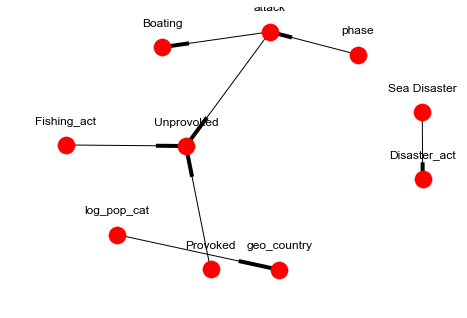

In [55]:
# graph the network
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from(model.edges())

pos = nx.spring_layout(G)
nx.draw(G, pos)
for k, v in pos.items():
    pos[k][1] += 0.1
nx.draw_networkx_labels(G, pos)

plt.show()

## Bayseian Network of Shark Attacks per Country-Year-Month

In [197]:
print(ve.query(variables=['attack'], evidence={'phase': 4})['attack'])

╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.9372 │
├───────────┼───────────────┤
│ attack_1  │        0.0388 │
├───────────┼───────────────┤
│ attack_2  │        0.0082 │
├───────────┼───────────────┤
│ attack_3  │        0.0051 │
├───────────┼───────────────┤
│ attack_4  │        0.0030 │
├───────────┼───────────────┤
│ attack_5  │        0.0023 │
├───────────┼───────────────┤
│ attack_6  │        0.0017 │
├───────────┼───────────────┤
│ attack_7  │        0.0010 │
├───────────┼───────────────┤
│ attack_8  │        0.0010 │
├───────────┼───────────────┤
│ attack_9  │        0.0001 │
├───────────┼───────────────┤
│ attack_10 │        0.0005 │
├───────────┼───────────────┤
│ attack_11 │        0.0004 │
├───────────┼───────────────┤
│ attack_12 │        0.0004 │
├───────────┼───────────────┤
│ attack_13 │        0.0002 │
├───────────┼───────────────┤
│ attack_14 │        0.0002 │
╘═══════════╧═══════════════╛


In [198]:
# conditional probability of provoked attack, given an unprovoked attack
print(ve.query(variables=['Provoked'], evidence={'Unprovoked': 1})['Provoked'])

╒════════════╤═════════════════╕
│ Provoked   │   phi(Provoked) │
╞════════════╪═════════════════╡
│ Provoked_0 │          0.9767 │
├────────────┼─────────────────┤
│ Provoked_1 │          0.0204 │
├────────────┼─────────────────┤
│ Provoked_2 │          0.0028 │
╘════════════╧═════════════════╛


In [199]:
# compared to the straight probability for a prokoked attack, we see that when there was an unprovoked attack it is
# also more likely that there was a provoked attack
print(ve.query(variables=['Provoked'])['Provoked'])

╒════════════╤═════════════════╕
│ Provoked   │   phi(Provoked) │
╞════════════╪═════════════════╡
│ Provoked_0 │          0.9889 │
├────────────┼─────────────────┤
│ Provoked_1 │          0.0098 │
├────────────┼─────────────────┤
│ Provoked_2 │          0.0013 │
╘════════════╧═════════════════╛


In [200]:
np.where(train_data['geo_country'].unique()=='United States')

(array([39]),)

In [201]:
# given that you're minding your own business, what happens to attacks
print(ve.query(variables=['attack'], evidence={'geo_country': 10})['attack'])

╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.9372 │
├───────────┼───────────────┤
│ attack_1  │        0.0388 │
├───────────┼───────────────┤
│ attack_2  │        0.0082 │
├───────────┼───────────────┤
│ attack_3  │        0.0051 │
├───────────┼───────────────┤
│ attack_4  │        0.0030 │
├───────────┼───────────────┤
│ attack_5  │        0.0023 │
├───────────┼───────────────┤
│ attack_6  │        0.0017 │
├───────────┼───────────────┤
│ attack_7  │        0.0010 │
├───────────┼───────────────┤
│ attack_8  │        0.0010 │
├───────────┼───────────────┤
│ attack_9  │        0.0001 │
├───────────┼───────────────┤
│ attack_10 │        0.0005 │
├───────────┼───────────────┤
│ attack_11 │        0.0004 │
├───────────┼───────────────┤
│ attack_12 │        0.0004 │
├───────────┼───────────────┤
│ attack_13 │        0.0002 │
├───────────┼───────────────┤
│ attack_14 │        0.0002 │
╘═══════════╧═══════════════╛


In [35]:
print(ve.query(variables=['attack'])['attack'])

╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.9372 │
├───────────┼───────────────┤
│ attack_1  │        0.0388 │
├───────────┼───────────────┤
│ attack_2  │        0.0082 │
├───────────┼───────────────┤
│ attack_3  │        0.0051 │
├───────────┼───────────────┤
│ attack_4  │        0.0030 │
├───────────┼───────────────┤
│ attack_5  │        0.0023 │
├───────────┼───────────────┤
│ attack_6  │        0.0017 │
├───────────┼───────────────┤
│ attack_7  │        0.0010 │
├───────────┼───────────────┤
│ attack_8  │        0.0010 │
├───────────┼───────────────┤
│ attack_9  │        0.0001 │
├───────────┼───────────────┤
│ attack_10 │        0.0005 │
├───────────┼───────────────┤
│ attack_11 │        0.0004 │
├───────────┼───────────────┤
│ attack_12 │        0.0004 │
├───────────┼───────────────┤
│ attack_13 │        0.0002 │
├───────────┼───────────────┤
│ attack_14 │        0.0002 │
╘═══════════╧═══════════════╛


In [202]:
print(ve.query(variables=['Unprovoked'])['Unprovoked'])

╒═══════════════╤═══════════════════╕
│ Unprovoked    │   phi(Unprovoked) │
╞═══════════════╪═══════════════════╡
│ Unprovoked_0  │            0.9191 │
├───────────────┼───────────────────┤
│ Unprovoked_1  │            0.0385 │
├───────────────┼───────────────────┤
│ Unprovoked_2  │            0.0099 │
├───────────────┼───────────────────┤
│ Unprovoked_3  │            0.0069 │
├───────────────┼───────────────────┤
│ Unprovoked_4  │            0.0047 │
├───────────────┼───────────────────┤
│ Unprovoked_5  │            0.0040 │
├───────────────┼───────────────────┤
│ Unprovoked_6  │            0.0037 │
├───────────────┼───────────────────┤
│ Unprovoked_7  │            0.0026 │
├───────────────┼───────────────────┤
│ Unprovoked_8  │            0.0026 │
├───────────────┼───────────────────┤
│ Unprovoked_9  │            0.0019 │
├───────────────┼───────────────────┤
│ Unprovoked_10 │            0.0019 │
├───────────────┼───────────────────┤
│ Unprovoked_11 │            0.0022 │
├───────────

## So we notice Surfing is not in our model. That is because there are few countries with high relative areas of recreational coastline. To make our model more relevant to us here in the United States, I will create a model with countries with the most instances of surfing/swimming/scubadiving activities.

In [203]:
full_cym.columns

Index(['geo_country', 'year', 'month', 'fatal', 'Boat', 'Boating', 'Provoked',
       'Sea Disaster', 'Unprovoked', 'Boating_act', 'Disaster_act',
       'Diving_act', 'Filming_act', 'Fishing_act', 'Handling_act',
       'Rowing_act', 'Shallow Water_act', 'Spear Fishing_act', 'Surfing_act',
       'Swimming_act', 'attack', 'phase', 'log_pop_cat'],
      dtype='object')

In [204]:
full_cym['Surfing_act'].sum()

472.0

In [205]:
rec_activities = ['Diving_act', 'Shallow Water_act', 'Surfing_act', 'Swimming_act', 'Rowing_act']
recreation_list = []
for i in range(0,len(full_cym)):
    c = 0
    for j in rec_activities:
        if full_cym[j][i] > 0:
            c += full_cym[j][i]
    recreation_list.append(c)

In [206]:
full_cym['recreation'] = recreation_list

In [207]:
rec_df = full_cym[rec_activities + ['recreation','geo_country']]

In [208]:
rec_df['recreation'].sum()

890.0

In [209]:
rec_countries = pd.DataFrame(rec_df.groupby('geo_country')['recreation'].sum())

In [210]:
a = np.array(rec_countries['recreation'])
p = np.percentile(a, 85)
print(p)

9.5


In [211]:
rec_countries.sort_values('recreation', ascending = False, inplace = True)

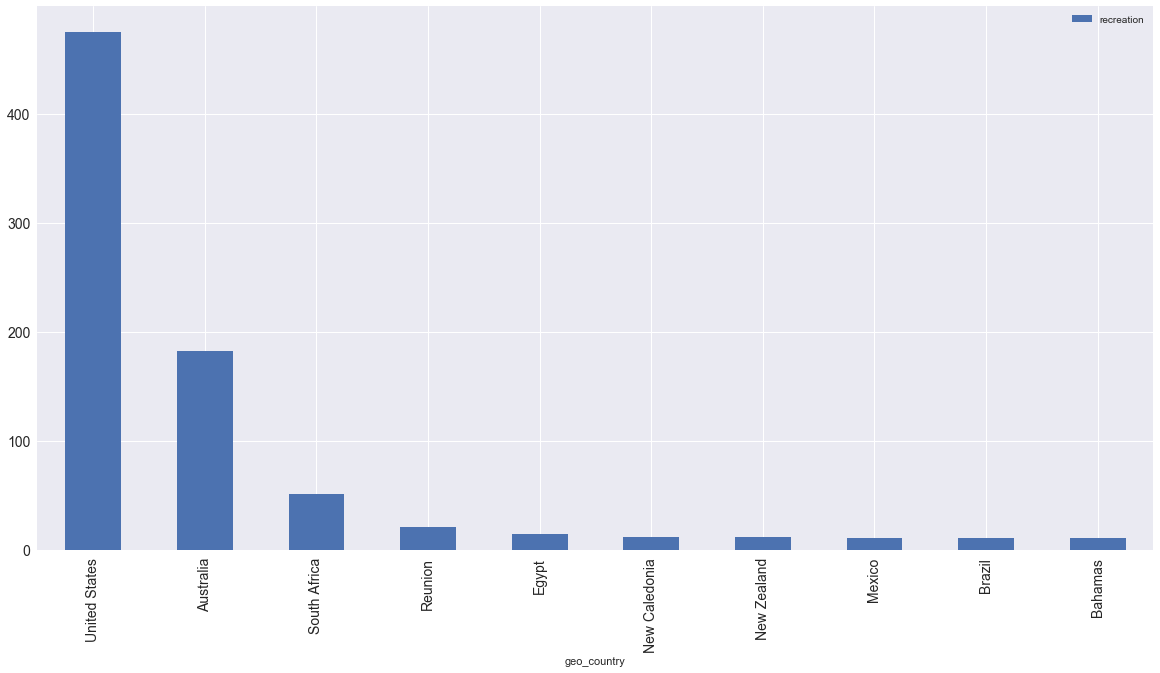

In [212]:
rec_countries[rec_countries['recreation']>p].plot(kind = 'bar', figsize = (20, 10), fontsize = 14)

In [213]:
#restrict data to just Countries in the 85th percentile of shark occurances and recreational activities.

In [214]:
full_cym = full_cym[full_cym['geo_country'].isin(['United States', 'Australia', 'South Africa', 'Reunion', 'Egypt', 'New Caledonia',
                                    'New Zealand', 'Mexico', 'Brazil', 'Bahamas'])]

In [215]:
del full_cym['recreation']

In [216]:
full_cym.columns

Index(['geo_country', 'year', 'month', 'fatal', 'Boat', 'Boating', 'Provoked',
       'Sea Disaster', 'Unprovoked', 'Boating_act', 'Disaster_act',
       'Diving_act', 'Filming_act', 'Fishing_act', 'Handling_act',
       'Rowing_act', 'Shallow Water_act', 'Spear Fishing_act', 'Surfing_act',
       'Swimming_act', 'attack', 'phase', 'log_pop_cat'],
      dtype='object')

In [217]:
del full_cym['Boat']
del full_cym['Boating']
del full_cym['Provoked']
del full_cym['Sea Disaster']
del full_cym['Unprovoked']

In [218]:
est = ConstraintBasedEstimator(full_cym)

In [219]:
# learn the structure of the network
skel, seperating_sets = est.estimate_skeleton(significance_level=0.15)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

Undirected edges:  [('Spear Fishing_act', 'Filming_act'), ('log_pop_cat', 'geo_country'), ('attack', 'Surfing_act'), ('attack', 'phase'), ('attack', 'Swimming_act'), ('fatal', 'Diving_act')]
PDAG edges:        [('Spear Fishing_act', 'Filming_act'), ('phase', 'attack'), ('log_pop_cat', 'geo_country'), ('attack', 'Surfing_act'), ('attack', 'Swimming_act'), ('attack', 'phase'), ('fatal', 'Diving_act'), ('Filming_act', 'Spear Fishing_act'), ('Surfing_act', 'attack'), ('Diving_act', 'fatal'), ('geo_country', 'log_pop_cat'), ('Swimming_act', 'attack')]
DAG edges:         [('attack', 'Surfing_act'), ('attack', 'phase'), ('Filming_act', 'Spear Fishing_act'), ('Diving_act', 'fatal'), ('geo_country', 'log_pop_cat'), ('Swimming_act', 'attack')]


In [220]:
# train the model to learn the conditional probability distributions
train_data, test_data = train_test_split(full_cym, test_size=0.05, random_state=1)
print(len(train_data))
print(len(test_data))

1254
66


In [221]:
# can't predict on data that falls outside the categories for which the model is trained
# shift data from the test set that is outside the train set back to the train set
outside_data = pd.DataFrame()
for col in train_data.columns:
    drop = test_data.loc[~test_data[col].isin(train_data[col])]
    if len(drop) > 0:
        outside_data = pd.concat([outside_data, test_data.loc[~test_data[col].isin(train_data[col].tolist())]])
        test_data = test_data.loc[test_data[col].isin(train_data[col].tolist())]
print(len(outside_data))
print(len(test_data))

0
66


In [222]:
# add outside data back to train data
train_data = pd.concat([train_data, outside_data])
print(len(train_data))
print(len(test_data))

1254
66


In [223]:
# train the model and find the conditional probability distributions
%time model.fit(train_data)
model.get_cpds()

CPU times: user 127 ms, sys: 1.71 ms, total: 129 ms
Wall time: 140 ms


[<TabularCPD representing P(Boating_act:2) at 0x11f718da0>,
 <TabularCPD representing P(Disaster_act:2) at 0x11e9665c0>,
 <TabularCPD representing P(Diving_act:3) at 0x11db4f438>,
 <TabularCPD representing P(Filming_act:2) at 0x11e721400>,
 <TabularCPD representing P(Fishing_act:5) at 0x105fadcf8>,
 <TabularCPD representing P(Handling_act:3) at 0x11e956128>,
 <TabularCPD representing P(Rowing_act:5) at 0x11d990278>,
 <TabularCPD representing P(Shallow Water_act:6) at 0x1065070b8>,
 <TabularCPD representing P(Spear Fishing_act:3 | Filming_act:2) at 0x11f8a4da0>,
 <TabularCPD representing P(Surfing_act:9 | attack:15) at 0x11db5d828>,
 <TabularCPD representing P(Swimming_act:8) at 0x11f87a828>,
 <TabularCPD representing P(attack:15 | Swimming_act:8) at 0x11f87a668>,
 <TabularCPD representing P(fatal:3 | Diving_act:3) at 0x11e79b7b8>,
 <TabularCPD representing P(geo_country:10) at 0x11dfa1198>,
 <TabularCPD representing P(log_pop_cat:6 | geo_country:10) at 0x11d990438>,
 <TabularCPD repres

In [224]:
# test the model by predicting number of attacks
test_data_drop = test_data.drop('attack', axis=1)
%time preds = model.predict(test_data_drop)

CPU times: user 2.5 s, sys: 9.04 ms, total: 2.51 s
Wall time: 2.51 s


In [225]:
preds.sum()

attack    38.0
dtype: float64

In [226]:
test_data['predicted'] = preds
agree = sum(test_data['attack']==test_data['predicted'])
print('{} accuracy'.format(round(agree/len(test_data)*100), 3))

85.0 accuracy


In [227]:
# conduct inference on the model (prop of outcomes given evidence)
print('Variable Elimination')
ve = VariableElimination(model)
# unconditional probability of attack
print(ve.query(variables=['attack'])['attack'])

# conditional probability of attack given 1 Sea Disaster
print(ve.query(variables=['attack'], evidence={'Surfing_act': 1})['attack'])

Variable Elimination
╒═══════════╤═══════════════╕
│ attack    │   phi(attack) │
╞═══════════╪═══════════════╡
│ attack_0  │        0.6962 │
├───────────┼───────────────┤
│ attack_1  │        0.1587 │
├───────────┼───────────────┤
│ attack_2  │        0.0423 │
├───────────┼───────────────┤
│ attack_3  │        0.0327 │
├───────────┼───────────────┤
│ attack_4  │        0.0183 │
├───────────┼───────────────┤
│ attack_5  │        0.0152 │
├───────────┼───────────────┤
│ attack_6  │        0.0112 │
├───────────┼───────────────┤
│ attack_7  │        0.0064 │
├───────────┼───────────────┤
│ attack_8  │        0.0064 │
├───────────┼───────────────┤
│ attack_9  │        0.0016 │
├───────────┼───────────────┤
│ attack_10 │        0.0032 │
├───────────┼───────────────┤
│ attack_11 │        0.0024 │
├───────────┼───────────────┤
│ attack_12 │        0.0024 │
├───────────┼───────────────┤
│ attack_13 │        0.0016 │
├───────────┼───────────────┤
│ attack_14 │        0.0016 │
╘═══════════╧══════

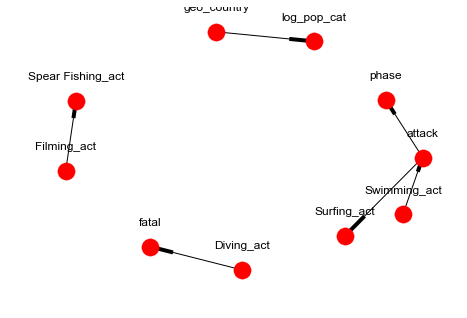

In [154]:
# graph the network
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from(model.edges())

pos = nx.spring_layout(G)
nx.draw(G, pos)
for k, v in pos.items():
    pos[k][1] += 0.1
nx.draw_networkx_labels(G, pos)

plt.show()

In [160]:
full_cym.groupby('fatal')[['Boating_act', 'Disaster_act', 'Filming_act', "Fishing_act", 'Handling_act', 'Diving_act',
                           'Rowing_act', 'Shallow Water_act', 'Spear Fishing_act', 'Surfing_act','Swimming_act']].sum()

,Boating_act,Disaster_act,Filming_act,Fishing_act,Handling_act,Diving_act,Rowing_act,Shallow Water_act,Spear Fishing_act,Surfing_act,Swimming_act
fatal,,,,,,,,,,,
0.0,4.0,1.0,2.0,92.0,25.0,29.0,41.0,72.0,48.0,383.0,161.0
1.0,1.0,1.0,1.0,8.0,1.0,9.0,3.0,5.0,7.0,59.0,31.0
2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,4.0,3.0


In [161]:
(9+4)/(9+29+4)

0.30952380952380953

In [162]:
(8+59)/(8+59+383)

0.14888888888888888

In [228]:
# train the model and find the conditional probability distributions
%time model.fit(train_data)
model.get_cpds('phase')

CPU times: user 130 ms, sys: 5.1 ms, total: 135 ms
Wall time: 142 ms


<TabularCPD representing P(phase:5 | attack:15) at 0x11d99dd30>

In [229]:
model.get_cpds('attack')

<TabularCPD representing P(attack:15 | Swimming_act:8) at 0x11e782588>